In [189]:
import os
import pandas as pd
import json
import numpy as np
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns


In [203]:
tfidf_info_path = f"/data/ephemeral/home/jhyeop/level2-mrc-nlp-11/outputs/wiki_tfidf_info.json"

if os.path.exists(tfidf_info_path):
    with open(tfidf_info_path, "r", encoding="utf-8") as f:
        tfidf_info = json.load(f)
        print(len(tfidf_info.values()))

56737


In [205]:
wiki_path = "/data/ephemeral/home/jhyeop/level2-mrc-nlp-11/data/wikipedia_documents.json"
if os.path.exists(wiki_path):
    with open(wiki_path, "r", encoding="utf-8") as f:
        # wiki_data = pd.read_json(wiki_path, orient="index")
        wiki_data = json.load(f)
    

In [20]:
len(tfidf_info.keys())

56737

In [206]:
newdict = {}
for v in wiki_data.values():
    if v['text'] not in newdict.keys():
        newdict[v['text']] = v
     

중복을 제거한 위키 문서 수는 56737개로, MRC 데이터 개수보다 월등히 많음. MRC 데이터 중에는 문서가 겹치는 것들도 있으므로, 현재 갖고 있는 문서 중에서 QA에 쓰인 적이 없는 문서가 훨씬 많다.

=> 쓰인 적 없는 문서에 대해서 질문-답변을 생성하는 증강 방식을 어떻게 시도해볼 수 있을까?

외부 데이터 사용 가능이라고 했으니까 GPT 사용해서 질문-답변 데이터를 우리 데이터셋 포맷에 맞게 생성하기??


In [207]:
newlist = list(newdict.values())
print(len(wiki_data.keys()), len(newlist))

60613 56737


위키 문서 중에는 마크다운 문법 태그나 줄바꿈 문자 같은 것들이 그대로 남아 있어서 `*`, `#`, `\n` 같은 것들이 토큰 또는 UNK 처리된 채로 tf-idf 점수가 높게 측정되는 경우가 있음 => 문서 구조는 살리면서 해당 태그들이 tf-idf 점수 계산에는 쓰이지 않도록 할 수 없을까?

ex. [DOC] 태그로 치환한 뒤 불용어 처리

### 질문 유형 분석

extraction based QA니까, 대체로 명사형의 답변을 요구하는 질문들일 거라고 예상.

그렇다면 사람 이름, 시간, 장소 등 요구하는 답변의 유형에 따라서 분류를 해볼 수 있지 않을까?

유형에 따라서 문서의 어느 토큰에 좀 더 주의를 기울일지 가중치를 부여해주는 방식을 실험해볼 수 있을 것 같다.


In [35]:
train_dataset = load_from_disk("/data/ephemeral/home/jhyeop/level2-mrc-nlp-11/data/train_dataset/train")
valid_dataset = load_from_disk("/data/ephemeral/home/jhyeop/level2-mrc-nlp-11/data/train_dataset/validation")
test_dataset = load_from_disk("/data/ephemeral/home/jhyeop/level2-mrc-nlp-11/data/test_dataset/validation")
wiki_path = "/data/ephemeral/home/jhyeop/level2-mrc-nlp-11/data/wikipedia_documents.json"
if os.path.exists(wiki_path):
    with open(wiki_path, "r", encoding="utf-8") as f:
        wiki_data = json.load(f)

In [179]:
def assign_question_type(example):
    question = example["question"]
    question_types = []
    time_words = [
        "언제", "며칠", "몇 년", "몇 달",
        "날짜는", "날은",
        "기간은", "기간인가", "어떤 기간", "어느 기간",
        "연도는", "연도인가", "어떤 연도", "어느 연도",
        "년도는", "년도인가", "어떤 년도", "어느 년도",
        "시기는?", "시기인가", "어떤 시기", "어느 시기",
        "시간은", "시간인가", "어떤 시간", "어느 시간",
        "시대는", "시대인가", "어떤 시대", "어느 시대",
        "연대는", "연대인가", "어떤 연대", "어느 연대",
        "해는?", "해인가", "어떤 해", "어느 해",
        "때는?", "때인가", 
        ]
    for time_word in time_words:
        if time_word in question:
            question_types.append("time")
            break
    
    person_words = [
        "누구", "누가", "사람은", "사람의 이름", 
        "인물은", "인물의 이름", "인물인가", "어떤 인물", "어느 인물",
        "적은?", "적의 이름", "적인가", "어떤 적", "어느 적",
        "왕은?", "왕의 이름", "왕인가", "어떤 왕", "어느 왕",
        "선수는", "선수의 이름", "선수인가", "어떤 선수", "어느 선수",
        ]
    for person_word in person_words:
        if person_word in question:
            question_types.append("person")
            break

    location_words = [
        "어디",
        "곳은", "곳의 이름", "곳인가", "어떤 곳", "어느 곳",
        "장소는", "장소의 이름", "장소 이름", "장소인가", "어떤 장소", "어느 장소",
        "나라는", "나라의 이름", "나라 이름", "나라인가", "어떤 나라", "어느 나라",
        "국가는", "국가의 이름", "국가 이름", "국가인가", "어떤 국가", "어느 국가",
        "건물은", "건물의 이름", "건물 이름", "건물인가", "어떤 건물", "어느 건물",
        "도시는", "도시의 이름", "도시 이름", "도시인가", "어떤 도시", "어느 도시",
        "마을은", "마을의 이름", "마을 이름", "마을인가", "어떤 마을", "어느 마을",
        "지역은", "지역의 이름", "지역 이름", "지역인가", "어떤 지역", "어느 지역",
        ]
    for location_word in location_words:
        if location_word in question:
            question_types.append("location")
            break

    organization_words = [
        "기관은", "기관의 이름", "기관인가", "어떤 기관", "어느 기관",
        "단체는", "단체의 이름", "단체인가", "어떤 단체", "어느 단체",
        "기업은", "기업의 이름", "기업인가", "어떤 기업", "어느 기업",
        "회사는", "회사의 이름", "회사인가", "어떤 회사", "어느 회사",
        "학교는", "학교의 이름", "학교인가", "어떤 학교", "어느 학교",
        "집단은", "집단의 이름", "집단인가", "어떤 집단", "어느 집단",
        "팀은", "팀의 이름", "팀인가", "어떤 팀", "어느 팀",
        "세력은", "세력의 이름", "세력인가", "어떤 세력", "어느 세력",
        "조직은", "조직의 이름", "조직인가", "어떤 조직", "어느 조직",
        "군대는", "군대의 이름", "군대인가", "어떤 군대", "어느 군대",
        ]
    for organization_word in organization_words:
        if organization_word in question:
            question_types.append("organization")
            break
    

    object_words = ["것은", "무엇", "것인가", "물건은", "물건의 이름", "물건인가", "방법은", "방법의 이름", "방법인가", "수단은", "수단의 이름", "수단인가", "기법은", "기법의 이름", "기법인가", "것의 이름"]
    for object_word in object_words:
        if object_word in question:
            question_types.append("object/method")
            break

    quantity_words = [
        "개수는", "몇", "수량은", "금액은", "얼마인가", "길이는", "거리는", "나이는", "수는"
    ]
    for quantity_word in quantity_words:
        if quantity_word in question:
            question_types.append("quantity")
            break

    if not question_types:
        question_types.append("others")

    example["question_type"] = question_types
    return example
    

In [180]:
train_dataset = train_dataset.map(assign_question_type)
valid_dataset = valid_dataset.map(assign_question_type)
test_dataset = test_dataset.map(assign_question_type)

Map: 100%|██████████| 3952/3952 [00:00<00:00, 5352.04 examples/s]


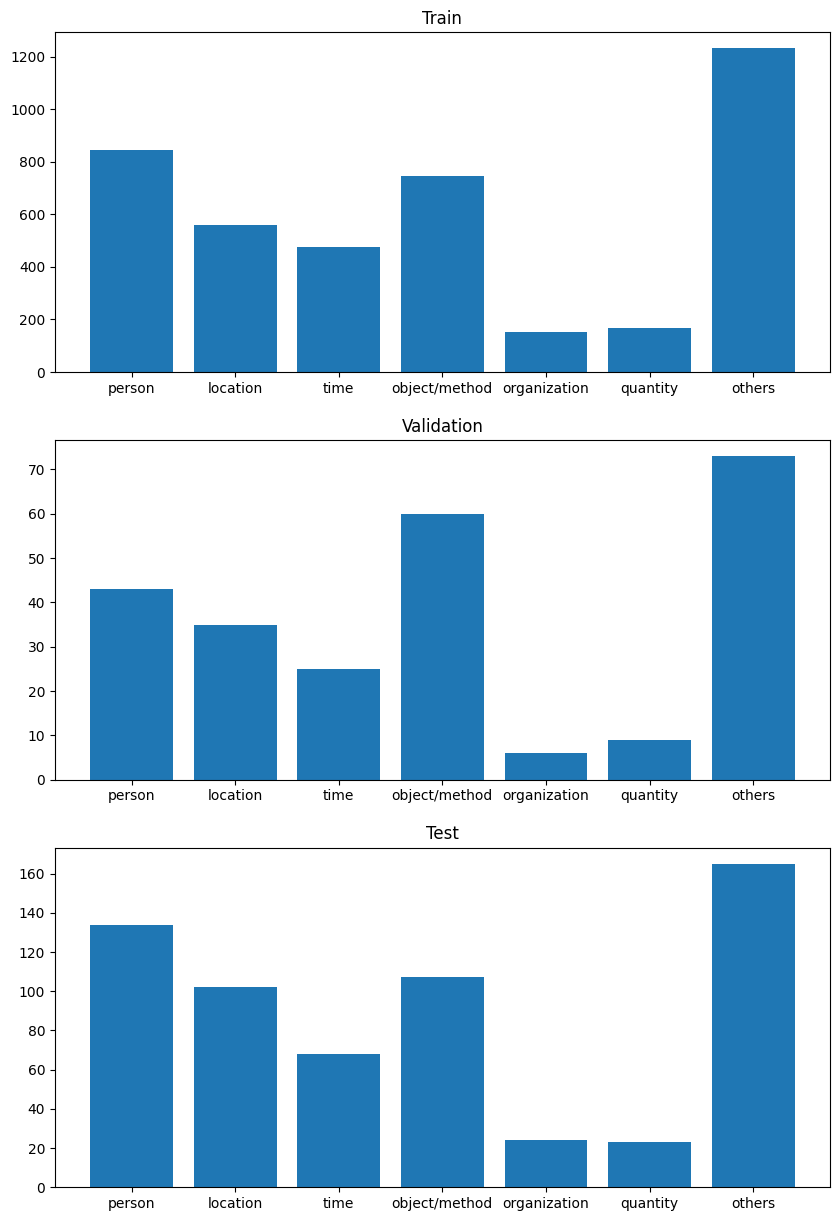

In [202]:
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

x = ["person", "location", "time", "object/method", "organization", "quantity", "others"]
y1 = [len(train_dataset.filter(lambda example: k in example["question_type"])) for k in x]
y2 = [len(valid_dataset.filter(lambda example: k in example["question_type"])) for k in x]
y3 = [len(test_dataset.filter(lambda example: k in example["question_type"])) for k in x]

axes[0].bar(x, y1)
axes[1].bar(x, y2)
axes[2].bar(x, y3)
axes[0].set_title("Train")
axes[1].set_title("Validation")
axes[2].set_title("Test")

plt.show()